<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/KAML_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary packages



In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

print(tf.__version__)

2.18.0


#Download data sample

In [ ]:
!wget -q https://github.com/csabiu/ML_tutorial/blob/master/class.tar.gz.parta{a,b,c,d,e,f,g,h,i}?raw=true > tmp
!cat class.tar.gz.parta*true > class.tar.gz
!gunzip class.tar.gz
!tar -xvf class.tar > tmp
!rm class.tar*
!rm tmp
!ls

class  sample_data


## Lets look at an image



(424, 424, 3)


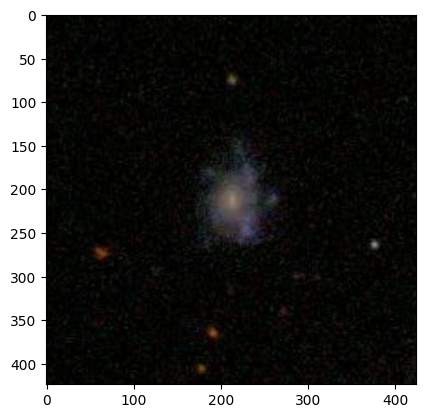

In [ ]:
jpgfile = Image. open("class/100134.jpg")
plt.imshow(jpgfile)
print(np.shape(jpgfile))


# Lets crop it

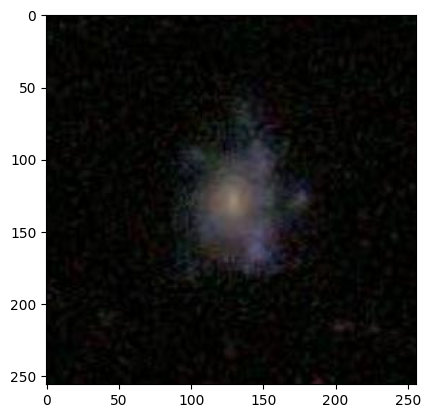

In [ ]:
plt.imshow(jpgfile.crop((84,84,340,340)))

# And lower the resolution

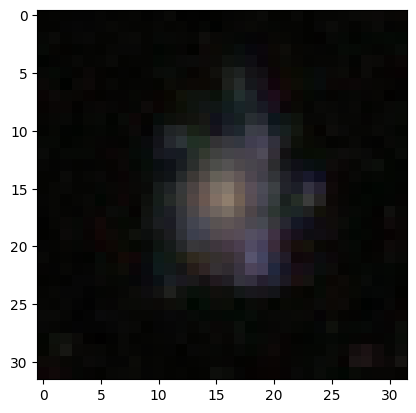

In [ ]:
target_size = 32
plt.imshow(jpgfile.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS))


# Split into RGB colors

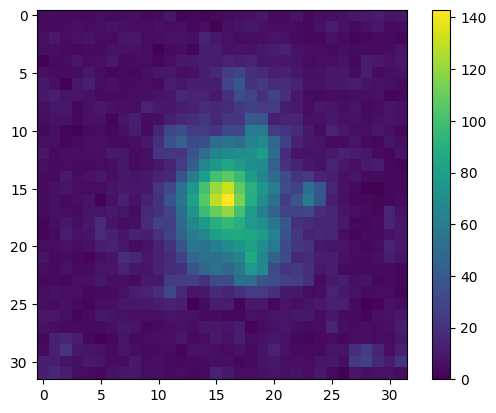

In [ ]:
r,g,b=jpgfile.split()
plt.imshow(r.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS))
plt.colorbar()

# Normalise the pixel values to (0,1)

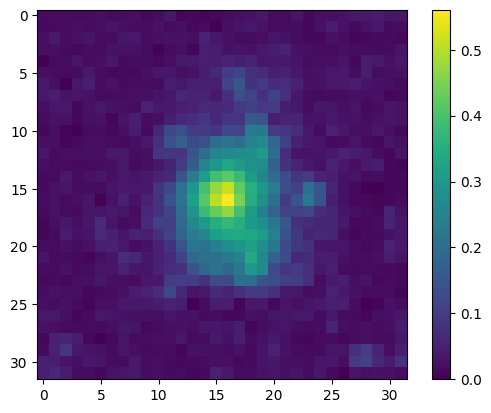

In [ ]:
im=np.zeros((target_size,target_size))
im[:,:]=r.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS)
im=im/255.
plt.imshow(im)
plt.colorbar()

# Load the labels (truth) data

(Image ID, galaxy type) - 0=smooth, 1=featured

In [ ]:
data=np.loadtxt("class/truth.txt",dtype='i')
print(np.shape(data))
labels=data[:,1]

print(data[1:10,:]) # print first 10 entries

(16885, 2)
[[100134      1]
 [100322      1]
 [100380      1]
 [100458      0]
 [100479      0]
 [100520      1]
 [100672      0]
 [100673      1]
 [100724      0]]


<ipython-input-9-cda73ee8ae0c>:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  data=np.loadtxt("class/truth.txt",dtype='i')


# Lets transform all the images and save into an array

In [ ]:
images=np.zeros((16885,target_size,target_size,3))
nn=0

for i in (data[:,0]):
  filename=str(int(i))+".jpg"
  jpgfile = Image. open("./class/"+filename)
  images[nn,:,:,:]=jpgfile.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS)
  nn=nn+1

images=images/255.
print(np.shape(images))

# remove color - make each chanel the same by averaging
images[:,:,:,0]=np.mean(images,axis=3)
images[:,:,:,1]=images[:,:,:,0]
images[:,:,:,2]=images[:,:,:,0]
print(np.shape(images))

(16885, 32, 32, 3)
(16885, 32, 32, 3)


# Split images and labels into training and test data

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.4, random_state=42)

print(np.shape(train_data))
print(np.shape(train_label))
print(np.shape(test_data))
print(np.shape(test_label))

(10131, 32, 32, 3)
(10131,)
(6754, 32, 32, 3)
(6754,)


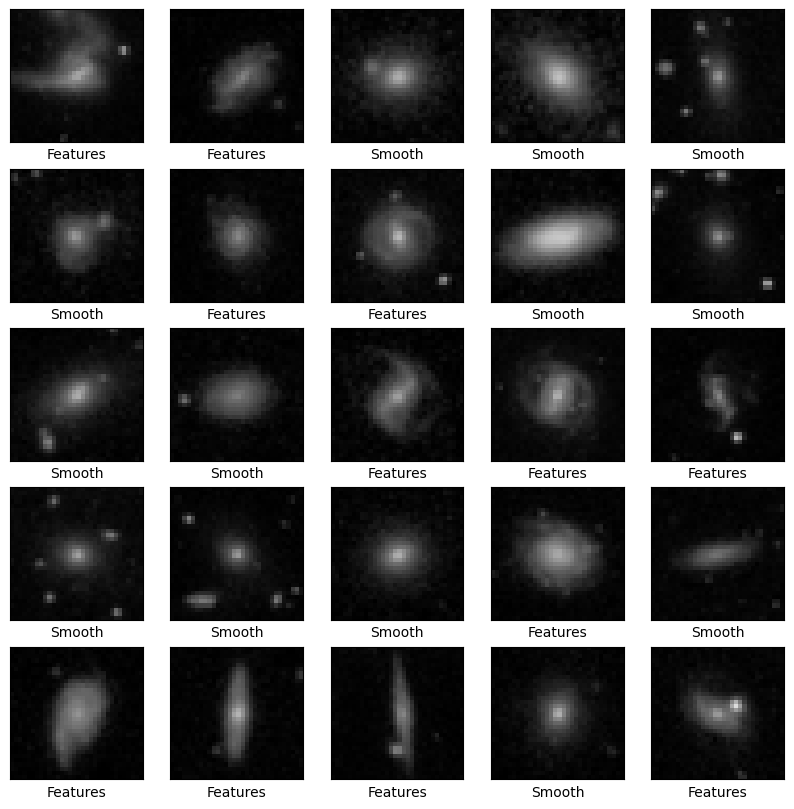

In [ ]:
class_names = ['Smooth', 'Features']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(train_label[i])])
plt.show()

# Define a simple neural network

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(target_size, target_size, 3)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)])
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,802 (768.76 KB)

 Trainable params: 196,802 (768.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6607 - loss: 0.6225 - val_accuracy: 0.7834 - val_loss: 0.5451
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7962 - loss: 0.5010 - val_accuracy: 0.8170 - val_loss: 0.4698
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8232 - loss: 0.4409 - val_accuracy: 0.8318 - val_loss: 0.4313
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8325 - loss: 0.4235 - val_accuracy: 0.8407 - val_loss: 0.4167
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8482 - loss: 0.3914 - val_accuracy: 0.8337 - val_loss: 0.4229
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8515 - loss: 0.3778 - val_accuracy: 0.8461 - val_loss: 0.4003
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8639 - loss: 0.3561 - val_accuracy: 0.8471 - val_loss: 0.3821
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8713 - loss: 0.3342 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8610 - loss: 0.3551
Test accuracy: 0.8645247220993042


Set up some of plotting functions

Text(0.5, 0, 'Epoch')

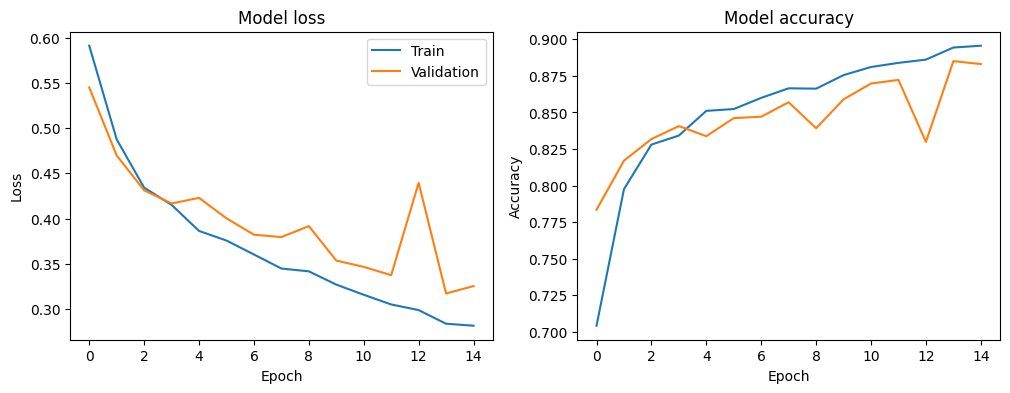

In [ ]:
# plot training loss and accuracy history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([0,1])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  #f, axarr = plt.subplots(2, sharex=True)
  #axarr[0].set_xticklabels(['smooth', 'features'])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Make predictions on test data from the trained model

In [ ]:
predictions = (model.predict(test_data[:,:,:]))

print("First 10 galaxies")
print("Predicted:",np.argmax(predictions[1:11],axis=1))
print("Truth:    ",np.int_(test_label[1:11]))

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
First 10 galaxies
Predicted: [0 0 0 0 1 0 1 1 0 1]
Truth:     [0 0 0 0 0 0 1 1 0 1]


# Lets visialise these classifications

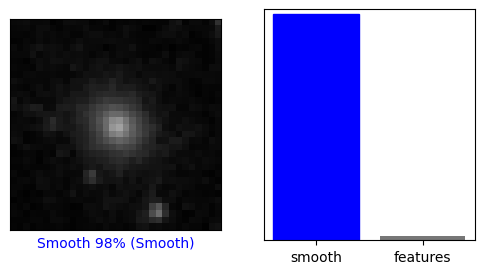

In [ ]:
i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, np.int_(test_label), test_data)
f=plt.subplot(1,2,2)
plot_value_array(i, predictions,  np.int_(test_label))
f.axes.set_xticklabels(["smooth","features"])
plt.show()

 Plot the first X test images, their predicted label, and the true label
 Color correct predictions in blue, incorrect predictions in red

<ipython-input-22-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-22-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-22-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-22-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-22-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

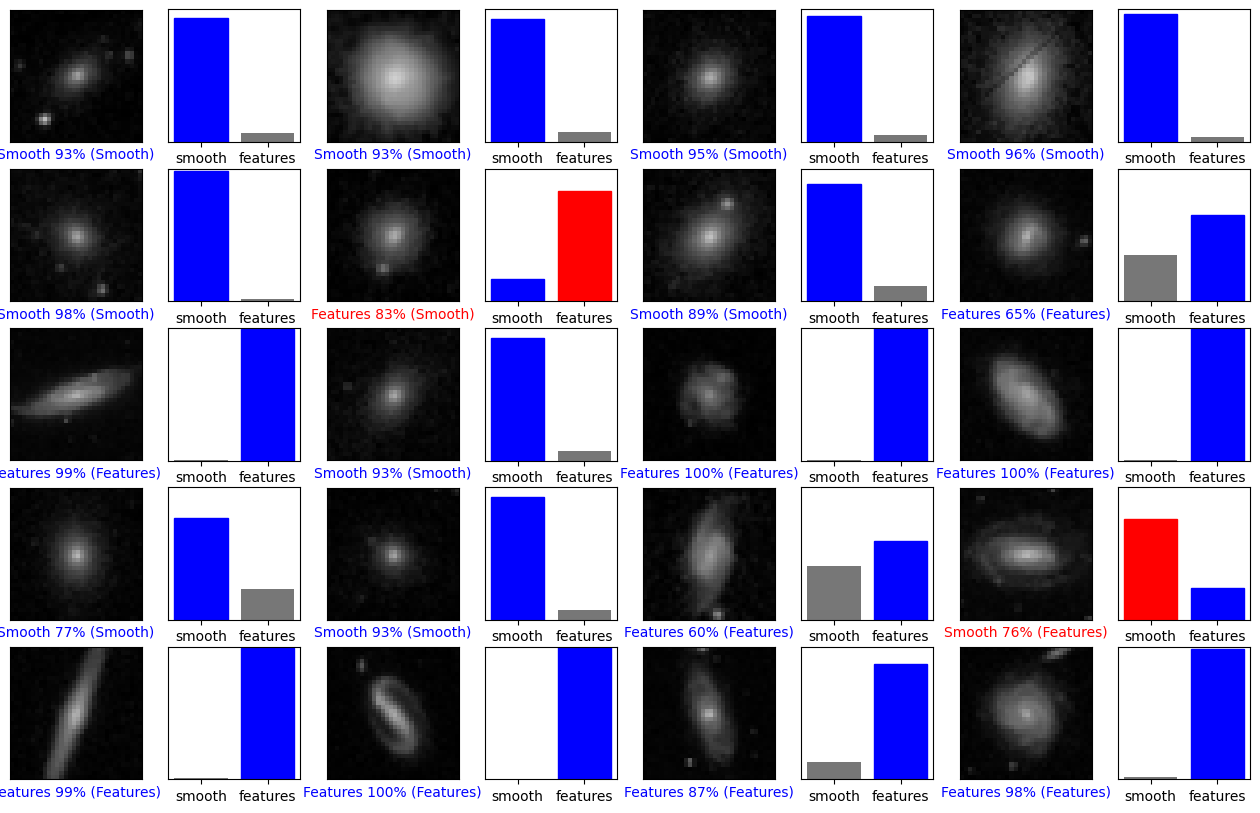

In [ ]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()


# Define a new convolutional neural network model

In [ ]:
def create_cnn_model():
  keras.backend.clear_session()
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size, target_size,3)))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(2, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = create_cnn_model()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,210 (493.01 KB)

 Trainable params: 126,210 (493.01 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model on the training data

In [ ]:
hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6177 - loss: 0.6206 - val_accuracy: 0.8880 - val_loss: 0.3004
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8626 - loss: 0.3332 - val_accuracy: 0.9038 - val_loss: 0.2546
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8931 - loss: 0.2678 - val_accuracy: 0.9221 - val_loss: 0.2064
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9172 - loss: 0.2136 - val_accuracy: 0.9472 - val_loss: 0.1465
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9417 - loss: 0.1635 - val_accuracy: 0.9403 - val_loss: 0.1568
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9421 - loss: 0.1551 - val_accuracy: 0.9344 - val_loss: 0.1670
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9473 - loss: 0.1502 - val_accuracy: 0.9541 - val_loss: 0.1228
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9465 - loss: 0.1381 - val_accuracy: 

# Now make prediction and visualise
# Compare to previous plot

Text(0.5, 0, 'Epoch')

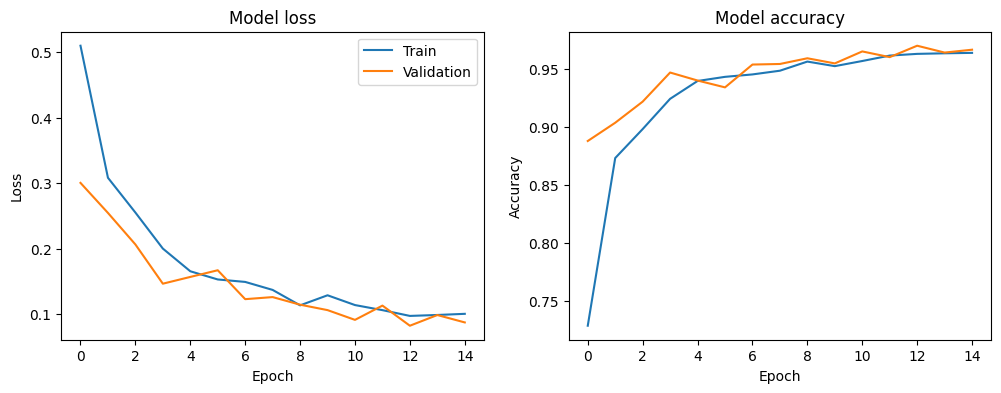

In [ ]:
# plot training history again
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<ipython-input-26-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-26-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-26-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-26-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-26-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

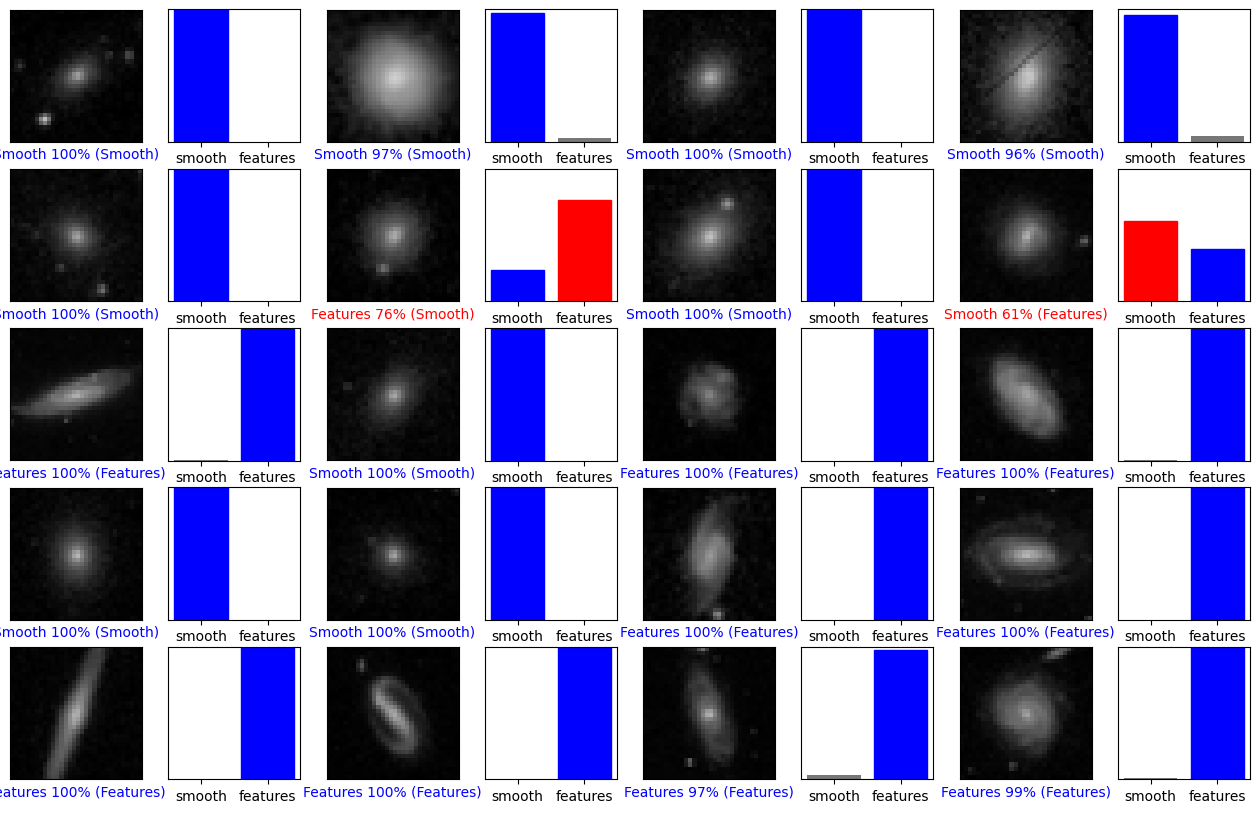

In [ ]:
predictions = model.predict(test_data)

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

# Now add some data augmentations

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras.preprocessing.image

# create fresh model
model = create_cnn_model()

# add data augmentation using a generator
datagen = ImageDataGenerator(width_shift_range=.2,
                             height_shift_range=.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=90,
                             fill_mode='nearest')

datagen.fit(train_data)

history = model.fit(datagen.flow(train_data, train_label, batch_size=30),
                        steps_per_epoch=train_data.shape[0] // 30,
                        epochs=15,validation_data=(test_data, test_label))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


337/337 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.6431 - loss: 0.6042 - val_accuracy: 0.8549 - val_loss: 0.3452
Epoch 2/15
  1/337 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8333 - loss: 0.3201

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8333 - loss: 0.3201 - val_accuracy: 0.8592 - val_loss: 0.3396
Epoch 3/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8441 - loss: 0.3658 - val_accuracy: 0.9023 - val_loss: 0.2661
Epoch 4/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8667 - loss: 0.3470 - val_accuracy: 0.8930 - val_loss: 0.2818
Epoch 5/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8911 - loss: 0.2805 - val_accuracy: 0.9377 - val_loss: 0.1880
Epoch 6/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9000 - loss: 0.2565 - val_accuracy: 0.9369 - val_loss: 0.1891
Epoch 7/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9017 - loss: 0.2485 - val_accuracy: 0.9079 - val_loss: 0.2311
Epoch 8/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9000 - loss: 0.2636 - val_accuracy: 0.8858 - val_loss: 0.2932
Epoch 9/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9129 - loss: 0.2224 - val_accuracy: 0.9169 - 

# Test the trained model on the test data

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9600 - loss: 0.1168
Test accuracy: 0.9582469463348389


# Now make prediction and visualise
# Compare to previous plot

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

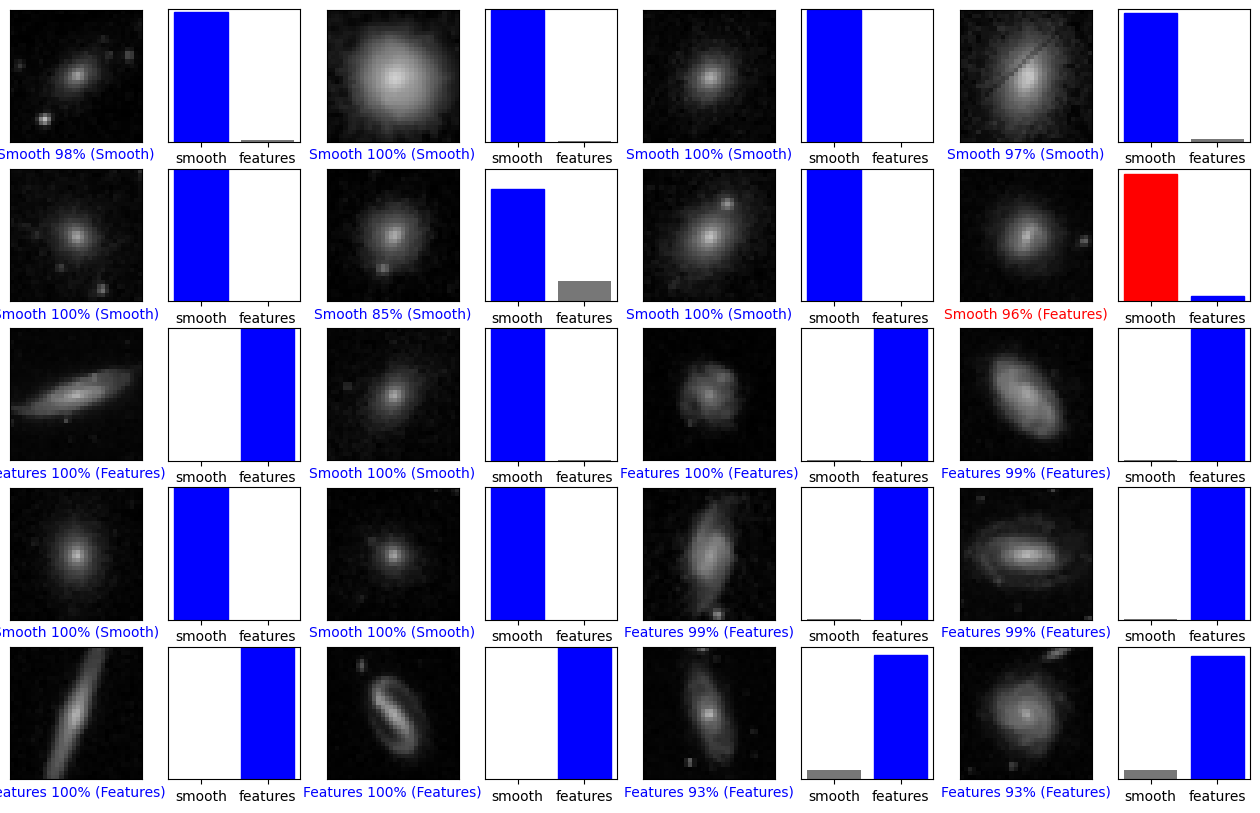

In [ ]:
predictions = (model.predict(test_data))

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Load a pretrained network
# Load the ResNet50 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(target_size, target_size, 3)))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) # 2 classes: smooth, featured

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_435']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8244 - loss: 0.4270 - val_accuracy: 0.9364 - val_loss: 0.1843
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9295 - loss: 0.1958 - val_accuracy: 0.9487 - val_loss: 0.1470
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9383 - loss: 0.1763 - val_accuracy: 0.9521 - val_loss: 0.1334
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9427 - loss: 0.1591 - val_accuracy: 0.9556 - val_loss: 0.1235
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9486 - loss: 0.1393 - val_accuracy: 0.9586 - val_loss: 0.1118
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9482 - loss: 0.1305 - val_accuracy: 0.9586 - val_loss: 0.1223
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9436 - loss: 0.1435 - val_accuracy: 0.9571 - val_loss: 0.1091
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9536 - loss: 0.1213 - val_accuracy: 0.96

In [ ]:
# Unfreeze the top layers of the base model
for layer in base_model.layers: # Unfreeze the last 50 layers
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fine-tune the model
hist2 = model.fit(train_data, train_label, epochs=10, validation_split=0.2) # Fine-tune for a few epochs

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_435']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


254/254 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.9255 - loss: 0.2035 - val_accuracy: 0.9679 - val_loss: 0.0816
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9594 - loss: 0.0998 - val_accuracy: 0.9714 - val_loss: 0.0758
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9695 - loss: 0.0805 - val_accuracy: 0.9743 - val_loss: 0.0636
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9757 - loss: 0.0633 - val_accuracy: 0.9443 - val_loss: 0.1321
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9784 - loss: 0.0593 - val_accuracy: 0.9773 - val_loss: 0.0603
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9868 - loss: 0.0356 - val_accuracy: 0.9822 - val_loss: 0.0520
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9856 - loss: 0.0416 - val_accuracy: 0.9832 - val_loss: 0.0500
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9848 - loss: 0.0394 - val_accurac

Text(0.5, 0, 'Epoch')

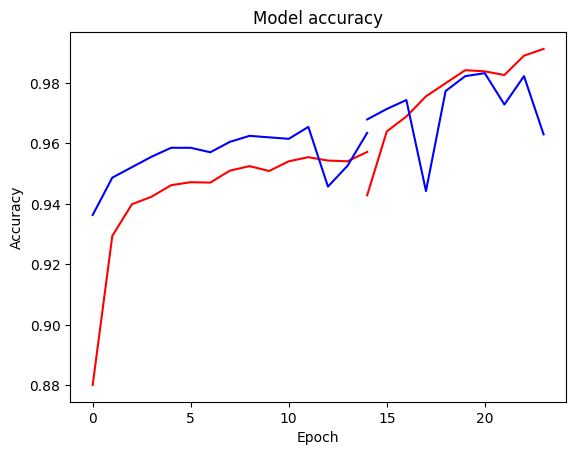

In [ ]:
plt.plot(hist.history['accuracy'],'r-')
plt.plot(hist.history['val_accuracy'],'b-')
plt.plot(np.arange(14,24),hist2.history['accuracy'],'r-')
plt.plot(np.arange(14,24),hist2.history['val_accuracy'],'b-')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_435']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


<ipython-input-80-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-80-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-80-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-80-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-80-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

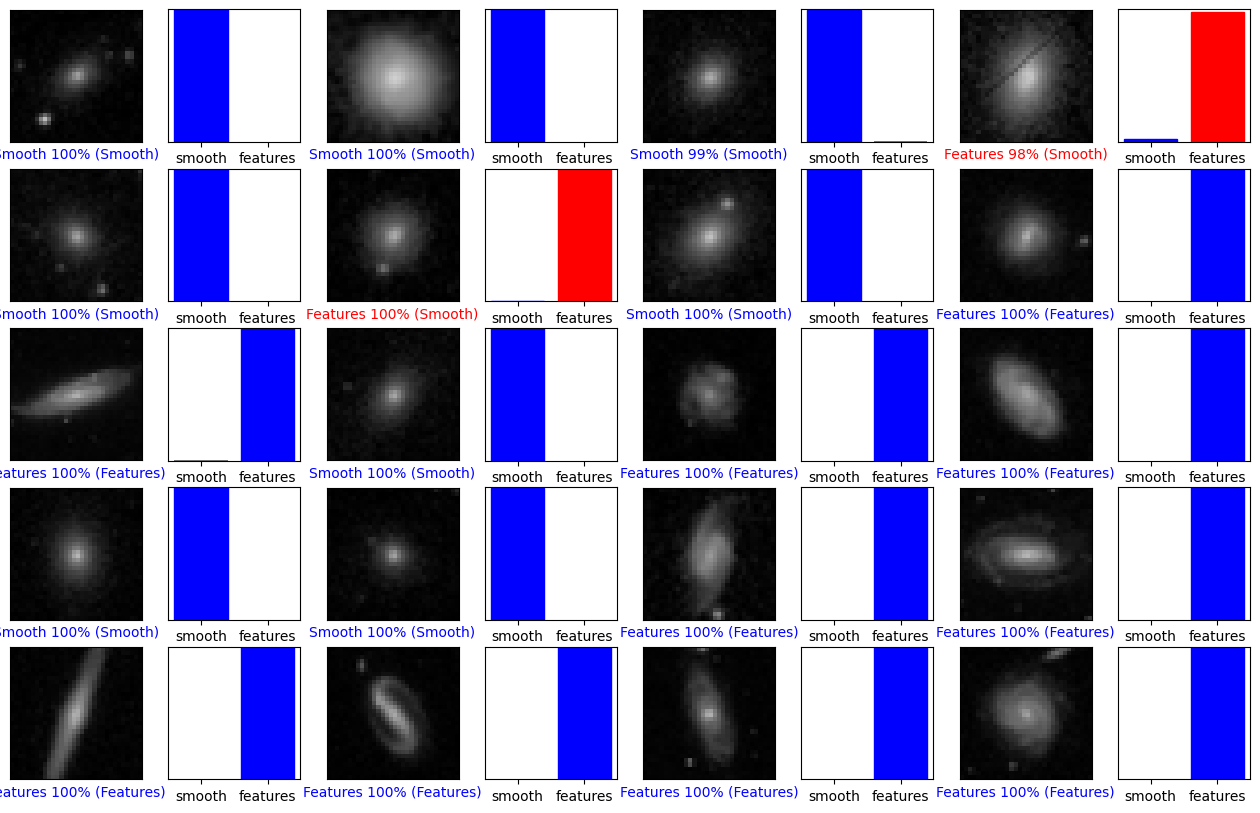

In [ ]:
predictions = (model.predict(test_data))

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9554 - loss: 0.1343
Test accuracy: 0.9546934962272644


In [ ]:
np.shape(model.layers)

(22,)